# Library import

In [1]:
import numpy as np
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split  #it came from update scikit learn. https://stackoverflow.com/questions/40704484/importerror-no-module-named-model-selection
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
%matplotlib inline

#import keras

NUM_CLASSES = 5
IMG_SIZE = 48

Using TensorFlow backend.


# function for preprocessing image. Able for RGB & Gray Image

In [2]:
#for gray scale
def preprocess_img(img):
    # Histogram normalization in y
#     hsv = color.rgb2hsv(img)
#     hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
#     img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]
    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img

def get_class(img_path):
    return int(img_path.split('/')[-2])

# Store the image and label in array. Run this cell if you need to do training. For testing no need to run it

In [3]:
imgs = []
labels = []
root_dir = '/home/atif/training_by_several_learning_process/flower_photos/flower_train_images/'
#path='/home/atif/training_by_several_learning_process/flower_photos/00000/'

#all_img_paths = glob.glob(path+ '5547758_eea9edfd54_n_000.jpg')

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.jpg')) #I have done the training with .ppm format image. If another type of image will come 
                                                                                    #them .ppm will be changed by that extension
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)

        if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
            #print("get it 2")
    except (IOError, OSError):
        print('missed', img_path)
        pass

X = np.array(imgs, dtype='float32') #Keeping the image as an array
Y = np.eye(NUM_CLASSES, dtype='uint8')[labels] #labels of the image


/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Processed 1000/3673
Processed 2000/3673
Processed 3000/3673


(3673, 48, 48)
(3673, 1, 48, 48)
4
(1, 48, 48)


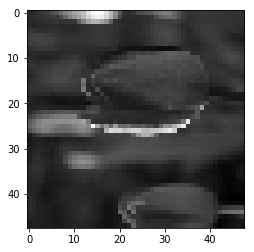

In [4]:
X = np.array(imgs, dtype='float32')
print(X.shape)
# plt.imshow(X[0])
plt.imshow(X[0],cmap="gray")
X = X.reshape(len(imgs),1,IMG_SIZE,IMG_SIZE)
# plt.imshow(X[0],cmap="gray")
print(X.shape)
print(X.ndim)
print(X[0].shape)

In [5]:
print(X.shape)
print(Y.shape)

(3673, 1, 48, 48)
(3673, 5)


# making a model. Run it for training and testing

In [6]:
def cnn_model():
#      padding='same'
    model = Sequential()

    model.add(Conv2D(1, (3, 3),
                     input_shape=(1,IMG_SIZE, IMG_SIZE),
                     activation='softmax'))
    model.add(Flatten())
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 46, 46)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2116)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10585     
Total params: 10,595
Trainable params: 10,595
Non-trainable params: 0
_________________________________________________________________


# Training phase. Storing the model also for further use

In [ ]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 100
model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          #np.resize(img, (-1, <image shape>)
          callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint('/home/atif/training_by_several_learning_process/flower_photos/train_model_flower/flw_gray_ch_1_ep_100_no_pad_softmax.h5', save_best_only=True)])